<a href="https://colab.research.google.com/github/Abdulla-asim/Machine-Learning/blob/main/PyTorch_Computer_Vision_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision Exercise

In [29]:
#import torch
import torch

# Checkk version
print(f"torch version: {torch.__version__}")

# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device: {device}")

torch version: 2.5.1+cu121
using device: cpu


### 1. What are the three areas in industry where computer vision is being used?


1. Robotics
2. Healthcare
3. Manufacturing

### 2. Search "what is overfitting in machine learning"?

When a model fails to generalize but appears very accurate on a particual dataset, it is said that the model is overfitting. This means that
the model perform poorly on new datasets.

### 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.

1. Regularization
2. Train with more data
3. Feature Selection
4. Reduce network complexity
5. Remove layers

## 5. Load the torchvision.datasets.MNIST() train and test datasets.

In [30]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='data',
    train = True,
    transform= ToTensor(),
    target_transform=None,
    download=True
    )

test_data = datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

In [31]:
# Check the data
img, label = train_data[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [32]:
import matplotlib.pyplot as plt

In [33]:
class_names = test_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

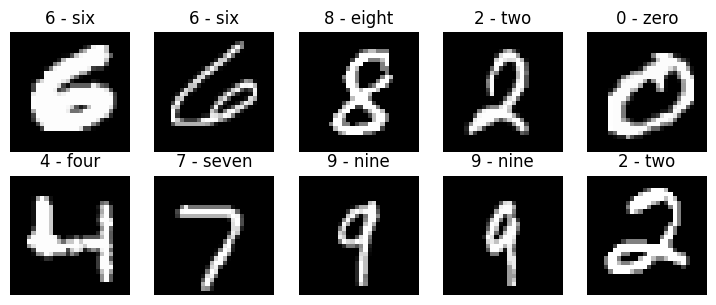

In [34]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 5, 5
for i in range (1, rows+cols + 1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using torch.utils.data.DataLoader, set the batch_size=32.

In [35]:
from torch.utils.data import DataLoader

In [36]:
BATCH_SIZE = 32

# Turn datasets into iterables
train_dataloader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [37]:
print(f"Length of train dataloader: {len(train_dataloader)} of size {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} of size {BATCH_SIZE}")

Length of train dataloader: 1875 of size 32
Length of test dataloader: 313 of size 32


In [38]:
len(train_data), len(test_data)

(60000, 10000)

## 8. Recreate model from the CNN Explainer website, also known as TinyVGG capable of fitting on the MNIST dataset.

In [39]:
from torch import nn

torch.manual_seed(42)

class MNISTModel0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.block_1 = nn.Sequential(
        nn.Conv2d(input_shape, hidden_units, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride= 1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2) # 28x28 -> 14x14
    )

    self.block_2 = nn.Sequential(
        nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2) # 14x14 -> 7x7
    )

    self.classifier = nn.Sequential(
        nn.Flatten(), # each unit(out of 10) becomes 7x7 = 49
        nn.Linear(hidden_units*7*7, output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.classifier(x)
    return x

model_0 = MNISTModel0(1, 10, len(class_names)).to(device)
model_0

MNISTModel0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [40]:
for X,y in train_dataloader:
  X = model_0(X.to(device))
  print(X.shape)
  break

torch.Size([32, 10])


In [41]:
def print_train_time(start: float, end: float, device: torch.device):
  total_time = end-start
  print(f"Train time on device {device}: {total_time:.3f} seconds")
  return total_time

In [42]:
from tqdm.auto import tqdm

def train_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn, acc_fn, optimizer: torch.optim, device: torch.device):
  torch.manual_seed(42)


  ### Training
  model.to(device)
  acc_fn.to(device)

  model.train()

  train_loss = 0
  train_acc = 0

  for X, y in tqdm(data_loader):
    X, y = X.to(device), y.to(device)

    # forward pass
    y_logits = model(X)

    # loss
    loss = loss_fn(y_logits, y)
    train_loss += loss
    acc = acc_fn(y, y_logits.argmax(dim=-1))
    train_acc += acc

    # optimzier zero grad
    optimizer.zero_grad()

    # loss bakwward
    loss.backward()

    # optimizer step
    optimizer.step()

  # Caculate loss and accuracy per batch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}%")

In [43]:
def test_step(model: nn.Module, data_loader: torch.utils.data.DataLoader, loss_fn, acc_fn, device: torch.device):
  model.eval()
  total_loss = 0
  acc = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      X, y = X.to(device), y.to(device)
      test_pred = model(X)
      loss = loss_fn(test_pred, y)

      total_loss += loss
      acc += acc_fn(y, test_pred.argmax(dim=-1))
    total_loss /= len(data_loader)
    acc /= len(data_loader)

  print(f"Epoch: {epoch} | Test Loss: {total_loss:.3f} | Test Accuraacy{acc:.2f}%")

In [44]:
try:
  import torchmetrics
except:
  !pip install torchmetrics
  import torchmetrics

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()
acc_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(class_names))

In [45]:
device

'cpu'

In [19]:
from timeit import default_timer as timer

start_cpu = timer()
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch {epoch}\n--------")
  train_step(model_0, train_dataloader, loss_fn, acc_fn, optimizer, device)

  test_step(model_0, test_dataloader, loss_fn, acc_fn, device)

end_cpu = timer()
print_train_time(start_cpu, end_cpu, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0
--------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.27960 | Train Accuracy: 0.91%
Epoch: 0 | Test Loss: 0.070 | Test Accuraacy0.98%
Epoch 1
--------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.07329 | Train Accuracy: 0.98%
Epoch: 1 | Test Loss: 0.054 | Test Accuraacy0.98%
Epoch 2
--------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.05625 | Train Accuracy: 0.98%
Epoch: 2 | Test Loss: 0.047 | Test Accuraacy0.99%
Epoch 3
--------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04774 | Train Accuracy: 0.99%
Epoch: 3 | Test Loss: 0.045 | Test Accuraacy0.99%
Epoch 4
--------


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04256 | Train Accuracy: 0.99%
Epoch: 4 | Test Loss: 0.039 | Test Accuraacy0.99%
Train time on device cpu: 498.038 seconds


498.03767362999986

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [46]:
def predict(model: nn.Module, test_data, device):
  model.eval()
  model.to(device)

  test_loss = 0
  test_acc = 0

  preds = []
  with torch.inference_mode():
    for sample, y in tqdm(test_data):
      sample = sample.unsqueeze(dim=0).to(device)

      pred_logits = model(sample)
      pred_label = torch.softmax(pred_logits, dim = -1).argmax(dim=-1)

      preds.append(pred_label)

  return torch.cat(preds).cpu()

In [21]:
predictions = predict(model_0, test_data, device)

  0%|          | 0/10000 [00:00<?, ?it/s]

NameError: name 'predictions' is not defined

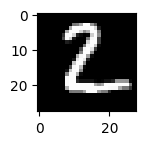

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,20))
rows = 10
cols = 10
for i in range(1, rows*cols+1):
  sample, y = test_data[i]
  plt.subplot(rows, cols, i)
  plt.imshow(sample.squeeze(), cmap="gray")
  plt.title(class_names[predictions[i]])
  plt.axis(False)

### 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [23]:
import mlxtend
mlxtend.__version__

'0.23.3'

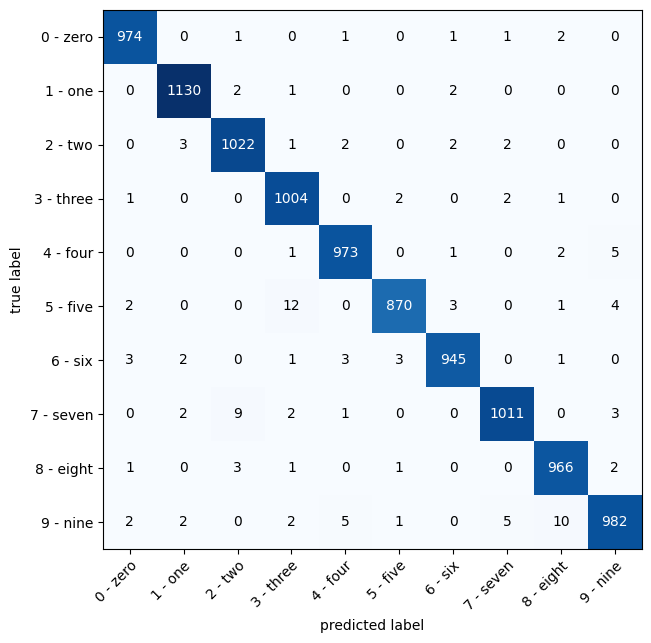

In [24]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix = ConfusionMatrix(task='multiclass', num_classes= len(class_names))
conf_tensor = conf_matrix(preds = predictions, target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = conf_tensor.numpy(),
    class_names = class_names,
    figsize=(10, 7)
)

### 12. Create a random tensor of shape [1, 3, 64, 64] and pass it through a  nn.Conv2d() layer with various hyperparameter settings (these can be any settings that you choose), what do you notice when the kernel_size parameter goes up and down.

In [48]:
random_tensor = torch.rand([1, 3, 64, 64])
random_tensor

tensor([[[[0.1441, 0.4637, 0.7894,  ..., 0.1222, 0.2993, 0.0453],
          [0.1184, 0.8728, 0.9093,  ..., 0.2053, 0.8934, 0.7372],
          [0.8015, 0.7304, 0.0178,  ..., 0.4556, 0.3060, 0.6154],
          ...,
          [0.5347, 0.3664, 0.4713,  ..., 0.9047, 0.1645, 0.8894],
          [0.8323, 0.5866, 0.2065,  ..., 0.4958, 0.6895, 0.4535],
          [0.0094, 0.5399, 0.4893,  ..., 0.5660, 0.9669, 0.0140]],

         [[0.0275, 0.0402, 0.2542,  ..., 0.9469, 0.8746, 0.4290],
          [0.2613, 0.9577, 0.7704,  ..., 0.3364, 0.4146, 0.6733],
          [0.6239, 0.9913, 0.5877,  ..., 0.1667, 0.8898, 0.8115],
          ...,
          [0.6860, 0.1662, 0.3710,  ..., 0.3029, 0.6021, 0.5331],
          [0.3013, 0.4333, 0.9756,  ..., 0.9473, 0.2036, 0.9628],
          [0.4978, 0.9530, 0.8268,  ..., 0.2127, 0.3968, 0.6574]],

         [[0.6059, 0.5688, 0.1456,  ..., 0.5585, 0.7470, 0.2718],
          [0.3886, 0.6950, 0.9444,  ..., 0.3923, 0.4057, 0.8209],
          [0.8817, 0.2373, 0.9755,  ..., 0

In [49]:
conv_layer = nn.Conv2d(
    in_channels = 3,
    out_channels = 64,
    kernel_size = 3,
    stride = 1,
    padding = 1
)

print(f"random tensor shape: {random_tensor.shape}")
convolved = conv_layer(random_tensor)
print(f"after convolution shape: {convolved.shape}")

random tensor shape: torch.Size([1, 3, 64, 64])
after convolution shape: torch.Size([1, 64, 64, 64])


### 13. Use a model similar to the trained model_2 from notebook 03 to make predictions on the test torchvision.datasets.FashionMNIST dataset

In [50]:
# Download fashionMNIST train and test
from torchvision import datasets
from torchvision import transforms

fashion_train = datasets.FashionMNIST(root=".",
                                           download = True,
                                           train = True,
                                           transform = transforms.ToTensor())

fashion_test = datasets.FashionMNIST(root=".",
                                     download = True,
                                     train = False,
                                     transform = transforms.ToTensor())

len(fashion_train), len(fashion_test)

(60000, 10000)

In [51]:
# Get class names of fashion dataset
fashion_class_names = fashion_train.classes
fashion_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [60]:
# Convert fashion datasets into data loaders
from torch.utils.data import DataLoader

fashion_train_dataloader = DataLoader(fashion_train,
                                batch_size = 32,
                                shuffle = True)

fashion_test_dataloader = DataLoader(fashion_test,
                                     batch_size = 32,
                                     shuffle = False)

len(fashion_train_dataloader), len(fashion_test_dataloader)

(1875, 313)

In [53]:
# model_2 is the same architecture as the mnist model
model_2 = MNISTModel0(input_shape=1,
                      hidden_units=10,
                      output_shape=10).to(device)

model_2

MNISTModel0(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [54]:
# Setup loss and optimizer
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr = 0.01)


In [55]:
# setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task = 'multiclass', num_classes = len(fashion_class_names)).to(device)

# Setup training testing loop
epochs = 5
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0

  ### Training
  model_2.train()
  for batch, (X_train, y_train) in enumerate(fashion_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # backprop and gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Adjust to loss/acc (find per epoch)
  train_loss /= len(fashion_train_dataloader)
  train_acc /= len(fashion_train_dataloader)

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward and loss
      y_pred = model_2(X_test)
      loss = loss_fn(y_pred, y_test)
      test_loss_total += loss
      test_acc += acc_fn(y_pred, y_test)

    # Adjust the acc and loss(to per epoch)
    test_loss_total /= len(fashion_test_dataloader)
    test_acc /= len(fashion_test_dataloader)

  # Print what's happening
  print(f"Epoch: {epoch} | Train Loss: {train_loss:.3f}, Train Acc: {train_acc:.2f} | Test Loss: {test_loss_total:.3f}, Test Acc: {test_acc:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.188, Train Acc: 0.57 | Test Loss: 0.626, Test Acc: 0.77
Epoch: 1 | Train Loss: 0.536, Train Acc: 0.80 | Test Loss: 0.489, Test Acc: 0.82
Epoch: 2 | Train Loss: 0.456, Train Acc: 0.84 | Test Loss: 0.429, Test Acc: 0.84
Epoch: 3 | Train Loss: 0.412, Train Acc: 0.85 | Test Loss: 0.448, Test Acc: 0.84
Epoch: 4 | Train Loss: 0.384, Train Acc: 0.86 | Test Loss: 0.389, Test Acc: 0.86


In [61]:
# Make predictions with trained model_2
test_preds = []
model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_test_dataloader):
    y_logits = model_2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim = -1) # last dim (same as next line)
    y_pred_labels = torch.argmax(y_pred_probs, dim = 1) # 2nd dim is also the last dim
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # Matplotlib likes cpu
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [62]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_test.targets)[0]
len(wrong_pred_indexes)

1363

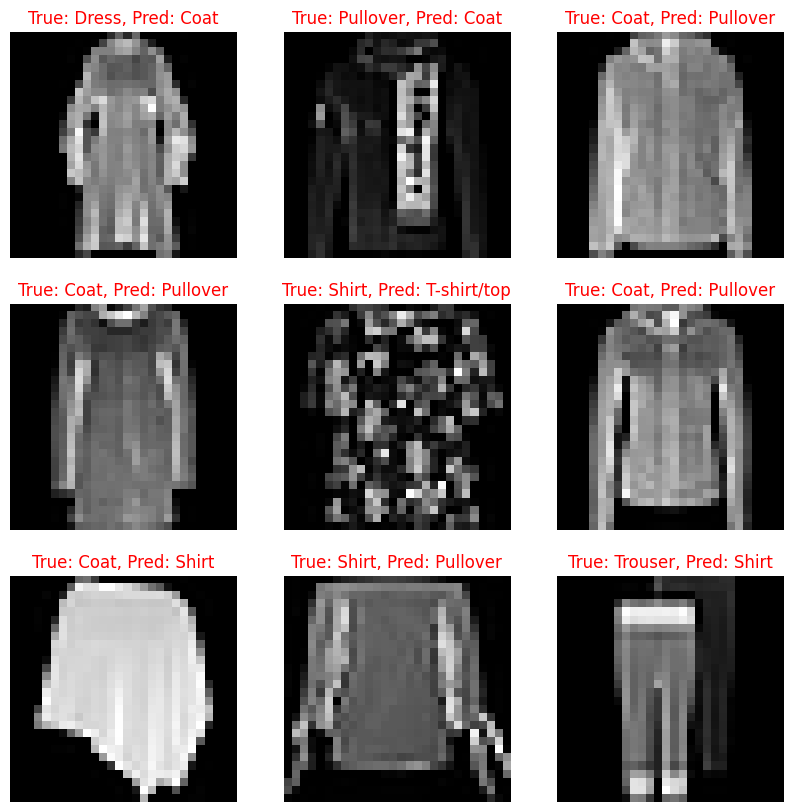

In [63]:
# Select random 9 predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k = 9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_class_names[fashion_test[idx][1]]
  pred_label = fashion_class_names[test_preds[idx]]

  # Plot the wrong prediction with its original lable
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_test[idx][0].squeeze(), cmap = 'gray')
  plt.title(f"True: {true_label}, Pred: {pred_label}", c = 'r')
  plt.axis(False)